# MNIST Machine Learning Showcase

## Import Necessary Data & Packages

Here, we import the packages necessary to run through the entirety of the present Assignment. Mostlty, these will be useful for matrix and vector operations, Principal Components (sklearn), and for general data visualization (matplotlib and seaborn).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import scipy.fft as scpfft
import scipy.stats as scpstats
import sklearn as skl
import sklearn.decomposition as skdec
from sklearn import preprocessing
from matplotlib.patches import Ellipse
import itertools
import seaborn as sns
import math

Next, we will import the data necessary for the completion of this project: the MNIST dataset, and check that the data was imported correctly. 

In [38]:
mnist_data = pd.read_csv('Data/train.csv')          # Read in the Training Data

## Data Preprocessing
### Data Normalization

Given that the data provided is pixel values ranging from 0 to 255, we can easily normalize our data as follows:

$X_{norm} = \frac{x_{i} - X_{min}}{X_{max}}$

Since $X_{min} = 0$, we can simply divide the entire dataset (except for the lables column) by 255, as produced by the code below.

In [3]:
mnist_data.loc[:,mnist_data.columns != 'label'] =  mnist_data.loc[:,mnist_data.columns != 'label']  / np.max(mnist_data.max())

Having normalized the data, we can take extract a random sample from the normalized data. Such that we may fulfill the requirements of the assignment, we will extract a sample of 5,000 images from the dataset.  

In [4]:
train_data = mnist_data.sample(frac = 1).reset_index(drop=True).iloc[0:5000]

### Feature Ranking and Selection

As it will be difficult to identify a relvant criteria for identifying outliers within this kind of dataset, which is composed of pixel values of hand-drawn images, we will first perform feature ranking and selection, and then remove outliers from the top features themselves. 

As such, it will be helpful to define a sort of analytical logic for our steps forward regarding feature reduction. 

Given the nature of the dataset, we will first perfrom a **2-dimensional Discrete Cosine Transform** of each of the images, extracting horizontal, vertical, and diagonal DCT coefficients for each of the images within our training set. Once we have extracted the DCT coefficients, we will perform PCA on each of the directions and extract the top features for each of the directions listed above. Once we have accomplished faeture extraction, we cane begin to remove outliers. 

#### 2-Dimensional DCT

We will perform the 2-dimensional Discrete Cosine Transform by leveraging scipy's fft pack and their built-in DCT function. This will be done by taking the current steps:


- We will define a function that calls scipy's DCT function twice within a given input matrix "A", and which will output the resulting matrix of DCT coefficients. 
    - This is necessary as scipy's original DCT function is not 2-dimensional, but only operates upon one dimension.
    - Note: There seem to be other packages capable of directly performing 2D-DCT, but these have not been imported for use in this project. 
- After we have defined this function, we will perform a sanity check in order to determine whether the outputted results are as desired, by applying the 2D DCT on a trial matrix. 
- We will then search through the training data to find 10 image representations of each numerical value, and save their indices to a new index array, using pandas' localization functionalities. 
- Once we have these matrices, we can perform a 2D DCT on each of the 100 resulting matrices, by iterating with a for-loop. 

Here we define the 2D DCT Function leveraging Scipy's FFT pack and its DCT built-in function

In [5]:
def dct2d(a):
    return scpfft.dct(scpfft.dct(a.T, norm='ortho').T, norm='ortho')

#### Extract the DCT Coefficient Matrices for all Images in the dataset
Here we will create a for-loop, call the 2D-DCT function defined above to create a 2D-DCT Coefficients Matrix for each of the Indices defined above. 
We will then check the first matrix of the output to make sure the data is of correct shape and logic. 

In order to extract the vertical, horizontal and diagonal coefficients of the transform, we will perform the following steps:


- Define a 28x28 Vertical Transform Mask
- Define a 28x28 Horizontal Transform Mask
- Define a 28x28 Diagonal Transform Mask
- From each of the three types of masks (corresponding to each type of transform), extract the indices of the features each of transform will choose to extract. 
- Once these have been retained, we will initialize a for-loop to perform the same DCT operations as that above, and proceed to extract each of the horizontal, vertical and diagonal transform from each of the DCT coefficient matrices. 

This methodology will yield three separate sets of DCT Coefficients: Horizontal, Vertical, and Diagonal. Each of these will contain the relevant coefficients for each of the transformed images. Below, we will define the various masks, and extract the indices of the valid features for each. 


In [6]:
v_mask =   np.array(
            [[0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
            [0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
            [0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
            [0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
            [0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
            [0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
            [0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
            [0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
            [0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
            [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1],
            [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1],
            [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1],
            [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1],
            [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]])

h_mask =    np.array(
            [[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
             [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
             [1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
             [1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
             [1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
             [1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
             [1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
             [1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
             [1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
             [1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
             [1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
             [1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
             [1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
             [1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
             [1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
             [1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
             [1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
             [1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
             [1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
             [1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
             [1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
             [1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
             [1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
             [1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
             [1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
             [1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
             [1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
             [1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]])

d_mask =   np.array(
            [[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
            [0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
            [0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
            [0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
            [0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
            [0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
            [0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0],
            [0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
            [0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
            [0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
            [0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
            [0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
            [0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
            [0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
            [0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
            [0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
            [0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
            [0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
            [0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
            [0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
            [0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
            [0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]])

# Extract Indices for Vertical Mask
vectorized_v_mask = np.matrix.flatten(v_mask)           
v_indices = []                                          
for i in range(len(vectorized_v_mask)):
    if vectorized_v_mask[i] == 1:
        v_indices.append(i)

# Extract Indices for Horizontal Mask
vectorized_h_mask = np.matrix.flatten(h_mask)
h_indices = []
for i in range(len(vectorized_h_mask)):
    if vectorized_h_mask[i] == 1:
        h_indices.append(i)

# Extract Indices for Diagonal Mask
vectorized_d_mask = np.matrix.flatten(d_mask)
d_indices = []
for i in range(len(vectorized_d_mask)):
    if vectorized_d_mask[i] == 1:
        d_indices.append(i)

#### Define a Function for 2D-DCT

In order to save ourselves a little time and effort down the line, we will define a function that automatically uses the indices extracted above to create a relvant array of data for each of the three directions described above, transformed by the 2D Discrete Cosine Transform. 

In [7]:
def dct2d(a):
    return scpfft.dct(scpfft.dct(a.T, norm='ortho').T, norm='ortho')

def HDV_DCT(data, v_s, d_s, h_s):
    
    # Initialize Vertical, Horizontal, and Diagonal Data Sets
    V_Data = []
    H_Data = []
    D_Data = []

    for index in range(len(data)):                                                       
        current_array = data.iloc[index]                                               # Extract relevant Matrix from Data
        temp_array = current_array.drop(['label'])                                          # Drop label column
        temp_matrix = temp_array.values.reshape([28,28])                                    # Reshape to 28x28 matrix
        temp_dct_data = dct2d(temp_matrix)                                                  # Perfrom 2D DCT Transform of current matrix
        vectorized_v_dct = np.matrix.flatten(np.multiply(temp_dct_data, v_mask))            # Apply Vertical Mask to 2D DCT Transform 
        vectorized_h_dct = np.matrix.flatten(np.multiply(temp_dct_data, h_mask))            # Apply Horizontal Mask to 2D DCT Transform 
        vectorized_d_dct = np.matrix.flatten(np.multiply(temp_dct_data, d_mask))            # Apply Diagonal Mask to 2D DCT Transform 
        V_Data.append(vectorized_v_dct[v_s])                                          # Append Vertical DCT Coefficients 
        D_Data.append(vectorized_d_dct[d_s])                                          # Append Diagonal DCT Coefficients
        H_Data.append(vectorized_h_dct[h_s])                                          # Append Horizontal DCT Coefficients 

    # Convert resultant datasets to numpy arrays for ease of computation
    V_Data_arr = np.array(V_Data)
    H_Data_arr = np.array(H_Data)
    D_Data_arr = np.array(D_Data)
    return V_Data_arr, H_Data_arr, D_Data_arr

We can then call our function to retrieve our different-direction arrays. 

In [8]:
V_Data_arr, H_Data_arr, D_Data_arr = HDV_DCT(train_data, v_indices, d_indices, h_indices)

#### Principal Components Analysis
Here, we perform Principal Components Analysis on the transforms generated in the section above, by adhering to the following logic:


- By defining a PCA function ourselves, leveraging scipy's linear algebra package (linalg), do extract eigenvectors and eigenvalues
- By leverageing sklearn's decomposition package
Once we have performed PCA, we will check the total amount of variance explained by a given number of components, which will guide our answer to Part D. 

The sklearn model by **fitting** the model to a given data set, and then transforming a second given array. Fitting and transforming at the same time will apply Principal Components Analysis to the dataset being reduced, which is what we will do below. The model itself will automatically rank the features by descending explained variance. 

For our purposes, we will first attempt PCA using only 5 components. Later, we will try different amounts of components to see how our model will change in accuracy. 

In [9]:
D_Data_PCA = skdec.PCA(5)                                    # Initialize PCA with n = 20
D_Data_Transform = D_Data_PCA.fit_transform(D_Data_arr)      # Apply to Diagonal Data Set
D_Data_Explained = D_Data_PCA.explained_variance_ratio_      # Extract explained variance

H_Data_PCA = skdec.PCA(5)                                    # Initialize PCA with n = 20
H_Data_Transform = H_Data_PCA.fit_transform(H_Data_arr)      # Apply to Diagonal Data Set
H_Data_Explained = H_Data_PCA.explained_variance_ratio_      # Extract explained variance

V_Data_PCA = skdec.PCA(5)                                    # Initialize PCA with n = 20
V_Data_Transform = V_Data_PCA.fit_transform(V_Data_arr)      # Apply to Diagonal Data Set
V_Data_Explained = V_Data_PCA.explained_variance_ratio_      # Extract explained variance

Now that we have successfully reduced our data, let's have a lookat hor our top 4 components relate to one another when plotted in two dimensions, as well as the probability distributions of each of the features tested. By doing this, we can attain a clear idea of whether performing this type of feature ranking and selection can provide some promising methodology for feature ranking within our data. 

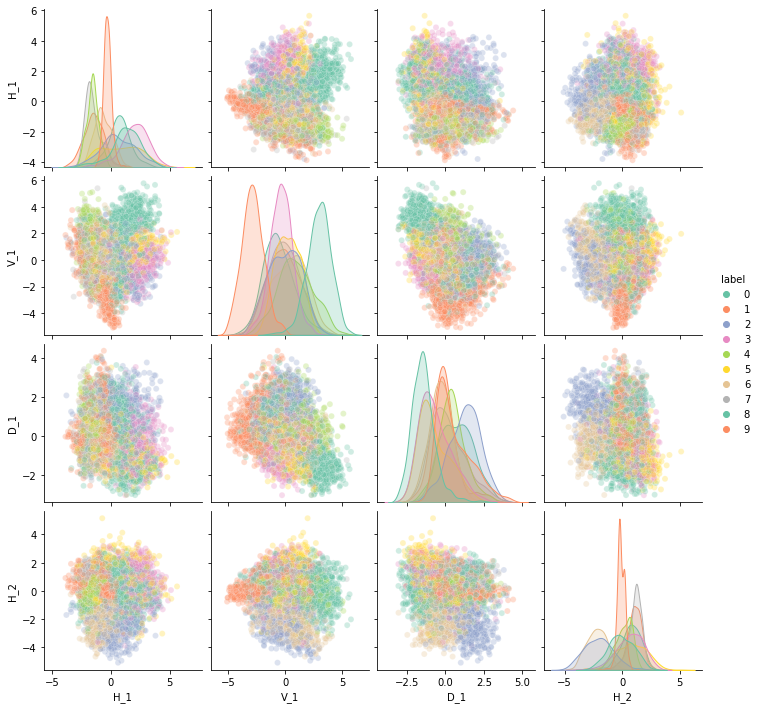

In [10]:
# Define number of Features per Direction
n_comps = 5

# Create a new DataFrame containing all of the Features and their Explained Variance
Ranked_Features = pd.DataFrame()
Explained_Vars = pd.DataFrame()
for index in range(n_comps):
    Ranked_Features['H_'+str(index+1)] = pd.DataFrame(H_Data_Transform).iloc[:,index]
    Ranked_Features['V_'+str(index+1)] = pd.DataFrame(V_Data_Transform).iloc[:,index]
    Ranked_Features['D_'+str(index+1)] = pd.DataFrame(D_Data_Transform).iloc[:,index]
    Explained_Vars['H_'+str(index+1)] = pd.DataFrame(H_Data_Explained).iloc[index]
    Explained_Vars['V_'+str(index+1)] = pd.DataFrame(V_Data_Explained).iloc[index]
    Explained_Vars['D_'+str(index+1)] = pd.DataFrame(D_Data_Explained).iloc[index]

# Sort the features by ascending explained variance
ranked_vars = pd.DataFrame(Explained_Vars.max(axis=0))
num_feats = 4
feature_list = []
for i in range(num_feats):
    current_id = ranked_vars.index[i]
    feature_list.append(current_id)

# Create the output dataframe and plot the data using Seaborn's pairplot
top_ranked_feats = Ranked_Features[feature_list]
top_ranked_feats = top_ranked_feats.join(train_data['label'])
sns.pairplot(top_ranked_feats, hue = 'label', 
palette = 'Set2', plot_kws = { 'alpha': 0.3})

Here, we can clearly see that the top components are relatively successful at separating our data, especially given the differing distributions portrayed by the plot for H_1. As such, we can consider this feature reduction methodology to be successful at reducing our data to a number of features that may prove extremely useful for creating a classification model.

Tweaking the hyperparameters of the feature selection algorithm above will be excellent to validate the model that we build. For example, testing whether using a larger or lower number of features impacts our classification accuracy will be key in determining what the optimal hyperparameters for our construction are. 

This space, as it so happens, also makes it a lot easier to remove outliers for each of the listed features. 

### Outlier Removal

In order to perform outlier removal, we will attempt two different methodologies:

- Mahalanobis Distnace Outlier Removal
- Z-Scoring Outlier Removal

It must be said that, in this situation, Mahalanobis distance may prove extremely time-consuming as, when increasing the number of total components & features maintained, we may run into some trouble. Namely, we might face removing a really high amount of data, as well as having to compute the mahalanobis distance across a very high number of combinations. Regardless, we will attempt to validate the two, in order to decide which of the two to include in our model down the line. 

#### Mahalanobis Distance
We will begin by attempting to validate Mahalanobis Distance. We begin this by creating a function that will calculate the total mahalanobis distance of a given observation and then return a list of outliers for a given combination of features. 

In [11]:
# Function to retain distances
def mahalanobis(x=None, data=None, cov=None):
    
    # Find Distance from Mean
    x_mu = x - np.mean(data)

    # Calculate covariance matrix if not provided
    if not cov:
        cov = np.cov(data.values.T)

    # Invert Covariance Matrix
    inv_covmat = np.linalg.matrix_power(cov, -1)

    # Return Left and Right Dot Products
    left = np.dot(x_mu, inv_covmat)
    mahal = np.dot(left, x_mu.T)
    new_df = data
    new_df['ma_dist'] = mahal.diagonal()
    return new_df

# Function to only get outliers
def MD_getOutliers(x, data, cl, deg_freedom):
    MD = mahalanobis(x,data)
    
    # Define Cutoff using chi2
    cutoff = scpstats.chi2.ppf(cl, deg_freedom)

    # Find and return outlier indices
    outliers = MD[MD['ma_dist'] > cutoff].index
    return np.array(outliers)

Let's attempt to apply Mahalanobis distance to a combination of features containing our top-two ranked components, H_1 and V_1. 

In [12]:
m_outlier_ids = []
for i in range(9):
    trial_1 = top_ranked_feats[top_ranked_feats['label'] == i][['H_1','V_1']]
    mahal_df = mahalanobis(trial_1,trial_1)
    m_outlier_ids.extend(MD_getOutliers(trial_1,trial_1, 0.95,2))
print(f' There exist a total of {len(m_outlier_ids)} outliers in the first two features')

 There exist a total of 469 outliers in the first two features


We can see, alraedy, that within a 95% confidence interval, we would already remove a total of 436 observations by only analyzing the first combination of features. 

#### Z-Scoring Outlier Removal
As such, we can begin to try to remove outliers by Z-Scoring, which only identify outliers along each of the feature axes, and will not look at outliers within the multidimensional space, but only within a single dimension. In the same way, we will define a function to return a list of indices, which we can then remove from the dataset. 

In [13]:
def z_score_outlier_identifier(input_data_set, feature, n_std):
    feature = [feature]
    fff = np.array(input_data_set)
    tt_x = fff[:,feature]
    # Load Data
    # Compute Mean and Standard Dev.
    mu_ = np.mean(tt_x)
    std_ = np.std(tt_x)

    # Compute Z score for each obs.
    z_ = (tt_x - mu_) / (std_)
    
    # Initialize Output
    outlier_idx = []

    # Loop through z-scores and extract outliers
    for i in range(len(z_)):
        if np.sqrt(z_[i]**2) > n_std:
            outlier_idx += [i]

    return outlier_idx

We can now attempt to have a look at how much data is removed from the first two features of our dataset, in order to have a comparison with the Mahalanobis Distance method above. 

In [14]:
outlier_ids = []
for i in range(1):
    outlier_ids += z_score_outlier_identifier(top_ranked_feats,i,2)

print(len(outlier_ids))

186


We can see that, as expected, the total number of identified outliers is much lower than the total number of outliers identified by the Mahalanobis distance method. As such, I think we can begin to make a decision regarding which methodology to use in our model. 

As it is not recommendable to remove outliers in multivariate space with this problem, we will choose to use Z-Scoring within the model we will build later in this assignment. Further still, by using Z-scoring we will have the ability to keep a higher proportion of our dataset for training. 

## Machine Learning Techniques

In order to further complete our model for classification, we will test two different machine learning methodologies aimed at helping us classify a given test set. For this project, we will validate the Parzen Window on the data generated above first, which will help us understand whether the features generated with the transformations above, can be used to successfully classify a given test input. The methodologies tested here will also include Fisher's LDA, to understand whether that's perhaps a better methodology for dividing the data and creating decision boundaries. 

### Parzen Window

We will begin by implementing a Parzen Window, following the simple logic below:

- Define a Gaussian Kernel Function
- Define a Parzen Window Function which will take in a training set, a test set, labels, a spread value and a number of classes, and return an array of assignment probability for each observation in the test set in relation to each of the classes provided. 

This technique may be extremely useful in helping us classify the data, especially given the transformations above and the distributions shown during our earlier exploration. What follows is an implementation of the Parzen Window, such that we may quickly call the function whenever we would like to estimate the class of a given data point. 

In [15]:
def GaussianKernel(point_x, dataset, h, D):
   
    # Perform point-by-point subtraction
    norm_vec = np.linalg.norm(point_x - dataset)
    
    # Define left-side of the equation
    lf = 1/((math.sqrt(2*math.pi))**D)
    
    # Exponentiate right-side of the equation
    exp_eq = -0.5*((norm_vec/h)**2)

    # Multiply the two and return result
    g = lf * math.exp(exp_eq)
    return g
    

def parzen_estimation_cl(training_set, test_set, labels, h, k):
    
    # Prepare data
    input_data = np.array(training_set)                             # C1; T:1
    test_set = np.array(test_set)                                   # C2; T:1
    labels = np.array(labels)                                       # C3; T:1
    

    # Initialize parameters necessary for iteration and outputs
  
    test_n = test_set.shape[0]                                      # C4; T:1
    P_k_i = np.zeros((test_n, k))                                   # C5; T:1

    for f in range(k):
        
        # Get index & data of each labeled datapoint in set
        l_idx = np.where(labels == np.unique(labels)[f])            # C6; T:K
        l_data = input_data[l_idx]                                  # C7; T:K
        N,D = l_data.shape                                          # C8; T:2K    


        P_i = np.zeros((test_n))                                    # C9; T:2K
        # Iterate over test and train sets
        for z in range(test_n):
            p_sums = 0.0                                            #C10; T:KL                                                                    
            for i in range(N):
                # Establish Gaussian Kernel Density by summing 
                # outputs of Gaussian Function defined above
                g_k_v = GaussianKernel(test_set[z], l_data[i], h,D) #C11; T:KNLG
                p_sums += (1/h**D)*(g_k_v)                          #C12; T:KNL

            # Divide by total number of entries in training
            P_i[z] = (p_sums/N)                                     #C13; T:KL

        # Get Probability estimation for the current class
        P_k_i[:,f] = P_i                                            #C14; T:K

    # Statement assignment and printing
    if test_set.shape[0] == 1:                                      #C15; T:1
        assignment = np.unique(labels)[np.argmax(P_k_i)]            #C16: T:3
        print(f'Test Point estimated to belong to class: {assignment}')
        
    return P_k_i


Here, we can attempt to use the model to classify a given random datapoint from the set we generated. We can then print whether the model assumed correctly, by checking against the test point's original label. 

In [16]:
# Reload Training Data & Labels
training = np.array(top_ranked_feats.drop(['label'], axis = 1))
labels_ = np.array(top_ranked_feats['label'])

# Create test point
test_point = np.array([[top_ranked_feats.iloc[100].drop(['label'])]])

# Test our implementation!
test = parzen_estimation_cl(training, test_point, labels_, 0.1, 10)
print(f"Original Point belonged to class: {top_ranked_feats['label'].iloc[100]}")

Test Point estimated to belong to class: 6
Original Point belonged to class: 6


Here, we will have a look at the entirety of linear space in order to generate some probability distributions for just the first two features. Having a visual for this will provide us with a better idea of exactly how the Parzen Window is able to classify different kinds of test points.

Text(0, 0.5, 'V_1')

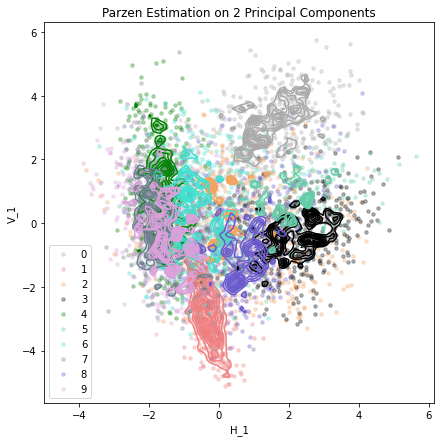

In [40]:
# Extract the top two features & labels
trf_2 = top_ranked_feats[['label','H_1','V_1']]
pr_tr_2 = np.array(trf_2.drop(['label'], axis = 1))
labels_ = np.array(top_ranked_feats['label'])

# Generate linear space test-set
h_1_test = np.linspace(-5,5,100)
v_1_test = np.linspace(-5,5,100)
test_1,test_2 = np.meshgrid(h_1_test,v_1_test)
test_set_ = np.vstack([test_1.ravel(), test_2.ravel()]).T

# Run the Model
estimates = parzen_estimation_cl(pr_tr_2,test_set_,labels_,0.1,10)

# Plot
plt.figure(figsize = (7,7))

colors = ['darkgray','lightcoral','sandybrown','black','green',
'mediumaquamarine','turquoise','slategray','slateblue','plum']

for i in range(10):
    
    # Plot Contours
    f = np.reshape(estimates[:,i], test_1.shape)
    levels = np.linspace(np.min(f)+0.1, np.max(f), 8)
    plt.contour(test_1, test_2, f, levels, colors = colors[i] , alpha = 1)
    
    # Plot Original Data Points
    l_idx = np.where(labels_ == np.unique(labels_)[i])
    plt.scatter(pr_tr_2[l_idx,0], pr_tr_2[l_idx,1], label = i, 
    c = colors[i] , alpha = 0.3, s = 12)

plt.legend()
plt.title("Parzen Estimation on 2 Principal Components")
plt.xlabel("H_1")
plt.ylabel("V_1")

Given the figure above, we have a decent representation of where the probability distributions of our model fall when attempting to classify various input points in the linear space. This visualization proves extremely hopeful for our model as it will allow us to further validate the notion that, even the first two features alone can hold significant power in predicting which label a given transformed input belongs to. 

As such, in our model, we would be able to transform test data using the same methodology (and PCA) as done for training (extracting the same features), and would then be able to categorize each of the inputted points. 

Before we proceed in building our model, however, let's attempt to have a look at whether Fisher's LDA is an appropriate method for this problem. 


### Fisher's Linear Discriminant Analysis

Here, we will define function that will perfom Fisher's Linear Discriminant Analysis, as we have performed in our Programming Assignment 1. By creating a function for LDA, we will be able to determine whether it is a methodology appropriate for further separating and classifying the data we have generated above. 

In [18]:
class LDA:

    # Define function for data preparation
    def prep_data(cols, dataset, target_label):

        # Pre Process Labels and create numerical vectors
        temp_lbls = preprocessing.LabelEncoder()
        labels = temp_lbls.fit_transform(dataset[target_label])
        Data = dataset.drop([target_label], axis=1)
        if len(cols) > 0:
            Data = Data[cols]
        return Data.values, labels

    # Define function for LDA fitting
    def fit(self, X, y):
        target_classes = np.unique(y)
        mean_vectors = []
        
        # Calculate Mean Vectors & Reshape
        for cls in target_classes:
            mean_vectors.append(np.mean(X[y == cls], axis=0))
        data_mean = np.mean(X, axis=0).reshape(1, X.shape[1])

        # Initialize and Calculate Between class scatter
        B = np.zeros((X.shape[1], X.shape[1]))
        for i, mean_vec in enumerate(mean_vectors):
            n = X[y == i].shape[0]
            mean_vec = mean_vec.reshape(1, X.shape[1])
            mu1_mu2 = mean_vec - data_mean
            B += n * np.dot(mu1_mu2.T, mu1_mu2)
        s_matrix = []

        # Initialize and Calculate within-class scatter
        for cls, mean in enumerate(mean_vectors):
            Si = np.zeros((X.shape[1], X.shape[1]))
            for row in X[y == cls]:
                t = (row - mean).reshape(1, X.shape[1])
                Si += np.dot(t.T, t)
            s_matrix.append(Si)

        # Reshape for following operation
        S = np.zeros((X.shape[1], X.shape[1]))
        for s_i in s_matrix:
            S += s_i
        
        # Perform inverse, matmul and eigen decomposition
        S_inv = np.linalg.inv(S)
        S_inv_B = S_inv.dot(B)
        eig_vals, eig_vecs = np.linalg.eig(S_inv_B)
        idx = eig_vals.argsort()[::-1]
        eig_vals = eig_vals[idx]
        eig_vecs = eig_vecs[:, idx]
        return eig_vecs, eig_vals

Having defined our Fisher's LDA, we can now run it on our generated dataset and plot the various combination of top ranked features, in order to understand whether we can use this methodology successfully to handle the classification problem above. 

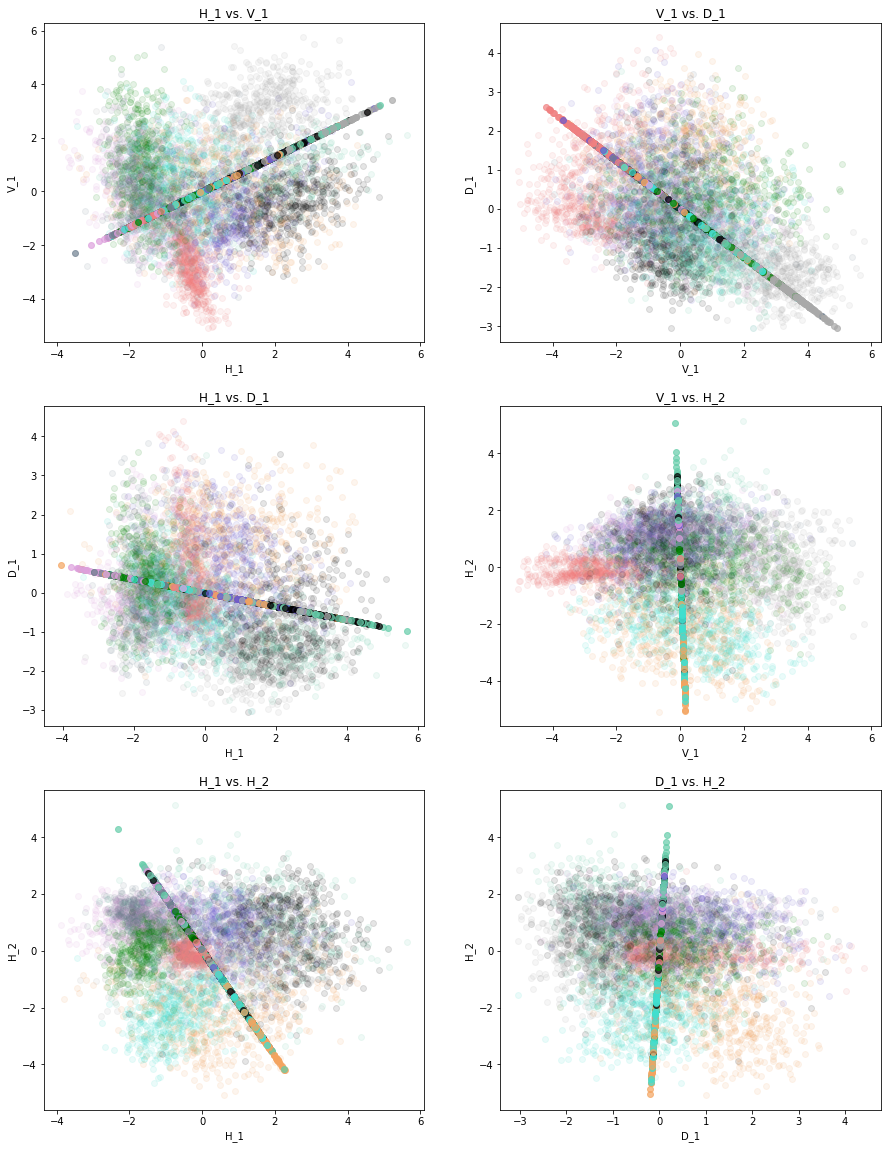

In [19]:
# Define combinations of features 
combo = list(itertools.combinations(top_ranked_feats.drop(['label'],axis =1).columns,2))

# Initialize plot
fig, ax = plt.subplots(3,2, figsize=(15,20))

# Iterate through combinations 
for i in range(len(combo)):
    if i < 3:
        axs = ax[i,0]
    else:
        axs = ax[i-3,1]
    colors = ['darkgray','lightcoral','sandybrown','black','green','mediumaquamarine','turquoise','slategray','slateblue','plum']

    # Perform LDA
    X, y = LDA.prep_data([combo[i][0], combo[i][1]], top_ranked_feats, 'label')
    lda = LDA()
    eig_vecs, eig_vals = lda.fit(X, y)

    # Extract top Eigenvector
    W = eig_vecs[:, :1]
    
    # Project along top Eigenvector and plot
    for point, pred in zip(X, y):
        axs.scatter(point[0], point[1], color=colors[pred], alpha=0.1)
        proj = (np.dot(point, W) * W) / np.dot(W.T, W)
        axs.scatter(proj[0], proj[1], color=colors[pred], alpha=0.7)
    axs.set_title(str(combo[i][0]) + ' vs. ' + str(combo[i][1]))
    axs.set_xlabel(combo[i][0])
    axs.set_ylabel(combo[i][1])

    

Given the results provided here, Fisher's LDA provides a less hopeful outlook for classification purposes. Hence, we will **choose the Parzen Window** as our method of choice when we build our model. 

### Model Creation

In order to properly tweak the various variables and hyper parameters of the model, we will generate a function for our model that will call upon all that we have built above in order to easily and quickly understand the changes in classification accuracy as change hyperparameters. This function will accept: 

- Training Data Set
- Testing Data-Set
- Number of Classes
- Number of Features to Reduce To
- H (spread for Parzen Window)
- Choice whether to normalize data
- Choice whether to remove outliers

By creating such a function, we will be able to quickly and efficiently determine the classification accuracy of the various combinations of the methods above, not including LDA & Mahalanobis Distances. 

In [20]:
def PCA_Parzen_Model(train_model, test_model, num_classes,
 num_features, h, normalize = bool, remove_outliers = bool):
    
    # Prepare the Data
    train_labels = train_model['label']
    test_labels = test_model['label']

    # Normalize if Desired
    if normalize:
        train_model = train_model / 255
        test_model = test_model / 255

    # Perform 2d DCT on test and train data    
    v_train_dct, h_train_dct, d_train_dct = HDV_DCT(train_model, v_indices, d_indices, h_indices)
    v_test_dct, h_test_dct, d_test_dct = HDV_DCT(test_model, v_indices,d_indices,h_indices)
    
    # Create PCA features for Training
    V_PCA_start = skdec.PCA(num_features)
    H_PCA_start = skdec.PCA(num_features)
    D_PCA_start = skdec.PCA(num_features)
    v_train_pca = V_PCA_start.fit_transform(v_train_dct)
    h_train_pca = H_PCA_start.fit_transform(h_train_dct)
    d_train_pca = D_PCA_start.fit_transform(d_train_dct)

    # Apply PCA transformation to Test Set
    v_test_pca = V_PCA_start.transform(v_test_dct)
    h_test_pca = H_PCA_start.transform(h_test_dct)
    d_test_pca = D_PCA_start.transform(d_test_dct)

    # Creat the two tests
    pr_train_data = np.concatenate([v_train_pca,h_train_pca,d_train_pca], axis =1)
    pr_test_data = np.concatenate([v_test_pca,h_test_pca,d_test_pca], axis =1)
    
    # Remove outliers if necessary
    if remove_outliers:
        outlier_ids = []
        for i in range(num_features*3):
            outs = z_score_outlier_identifier(pr_train_data,i,2)
            outlier_ids += outs
        pr_train_data = np.delete(pr_train_data,outlier_ids, axis = 0)
        train_labels = train_labels.drop(train_labels.index[outlier_ids], axis = 0)

    # Perform estimation
    parzen_estimate = parzen_estimation_cl(pr_train_data, pr_test_data, 
    train_labels, h, num_classes)
    assignments = []
    for i in range(len(pr_test_data)):
        assignments.append(np.argmax(parzen_estimate[i]))

    # Calculate accuracy
    accuracy = np.sum(assignments == test_labels) / len(assignments)
    return assignments, accuracy

Let's try out our model on a given set of parameters, with:

- A random set of training data of length 8000
- A random test set of length 1000
- 5 PCA Features per Direction
- A spread of 0.1 (for Parzen Window)
- Normalization 
- No Outlier Removal

We will try this out with the settings above, but we will then be able to test various combinations of the methods above, as per the Progamming Assignment guidelines. 

In [21]:
train_data_ = mnist_data.sample(frac = 1).reset_index(drop=True).iloc[0:8000]
test_data_ = mnist_data.sample(frac = 1).reset_index(drop=True).iloc[0:1000]

ass, acc = PCA_Parzen_Model(train_data_,test_data_,10,5,0.1,True,False)
print(f'Accuracy: {acc}')

Accuracy: 0.726


Now that we've got a model with tweakable parameters, we can use KFold Cross Validation, and further try and understand which combination of the methods tested above function the best together to produce the highest classification accuracy. 

## KFold Cross Validation

As we embark further upon our validation journey, it's of course helpful to define a function to perform KFold Cross validation. The code below will serve that precise function by creating a moving indexer which will create a number of testing and training datasets according to the total number of folds desired. 

Further still, we have added a "randomization" parameter to shuffle the data if desired, as well as a label list parameter to evenly spread labels should we desire to do so. 

In [22]:
def kFold(dataset,folds, label_list, randomize = bool):
    
    # Shuffle data if desired
    if randomize == True:
        dataset = dataset.sample(frac = 1).reset_index(drop = True)

    # Space Labels out evenly if desired
    if label_list != None:
        labels_ = np.array(label_list)
        l_ids = []
        for i in range(len(np.unique(labels_))):
            l_ids += np.where(labels_ == np.unique(labels_)[i])
        l_ids = np.array(l_ids)
        new_ids = []
        for i in range(l_ids.shape[1]):
            for k in range(l_ids.shape[0]):
                new_ids.append(l_ids[k,i])
        
        dataset = dataset.iloc[new_ids].reset_index(drop=True)
    
    # Define number of observations per fold
    obs_per_fold = int(len(dataset)/folds)

    # Initialize moving-indexer and outputs
    id_mover = []
    k_fold_train = {}
    k_fold_test = {}

    # Move indexer through data and extract train and test sets
    # Returns two dictionaries of datasets of len = k
    for i in range(folds):
        id_mover = [obs_per_fold*i, obs_per_fold*i + obs_per_fold]
        k_fold_test[i] = dataset.iloc[id_mover[0]:id_mover[1]] 
        k_fold_train[i] = dataset.drop(k_fold_test[i].index)

    return k_fold_train, k_fold_test

Now that we've created our KFold algorithm, let's test it out on the first 5,000 observations of the MNIST Dataset. This way, we will have the ability to quickly validate our algorithm above. 

In [23]:
mnist_k_train, mnist_k_test = kFold(mnist_data.iloc[0:8000], 5, None, randomize = False)

We can now iterate over each of the training and testing sets and print out the total accuracy of the model through each of the folds:

In [24]:
for i in range(5):
    ass, acc = PCA_Parzen_Model(mnist_k_train[i],mnist_k_test[i],10,5,0.1,False,False)
    print(f"Fold: {i}; Accuracy: {acc}")

Fold: 0; Accuracy: 0.923125
Fold: 1; Accuracy: 0.934375
Fold: 2; Accuracy: 0.9275
Fold: 3; Accuracy: 0.921875
Fold: 4; Accuracy: 0.910625


By using KFold cross-validation, we can see that our model, using the current parameters, has a classification accuracy that remains rather stable. This is great news, as we can now move forward to trying out the various combinations in an attempt to understand the best combinations of the methods above. 

## Method Analysis

### Best Combination of Methods

In order to determine the best combination of methods, we can now leverage our model to quickly and easily determine which combination of our model parameters earns us the best results. We will test and cross-validate across the following axes:

- Normalization 
- Outlier Removal
- Number of Features Extracted

Let's begin by having a look at the total accuracy with the data normalized, and outliers removed:

In [27]:
ass_3, acc_3 = PCA_Parzen_Model(mnist_k_train[0],mnist_k_test[0],10,5,0.1,True,True)
print(f'Accuracy: {acc_3}')

Accuracy: 0.7425


Now, let's attempt to have a look at the accuracy of our model if we choose not to remove outliers, but choose to normalize our data:

In [26]:
ass_2, acc_2 = PCA_Parzen_Model(mnist_k_train[0],mnist_k_test[0],10,5,0.1,True,False)
print(f'Accuracy: {acc_2}')

Accuracy: 0.721875


Interestingly, we note that the accuracy decreases when we choose to not remove outliers. We can now move on and have a look at the accuracy when choosing to remove outliers, but choose not to normalize our data. 

In [32]:
ass_4, acc_3 = PCA_Parzen_Model(mnist_k_train[0],mnist_k_test[0],10,5,0.1,False,True)
print(f'Accuracy: {acc_3}')

Accuracy: 0.8925


Interestingly, choosing to not normalize our data yielded much better classification accuracy than normalizing our data did. This is a rather interesting result, and one worth exploring further. Let's attempt to use K-Fold validation on the system above:

In [35]:
for i in range(5):
    ass_4, acc_3 = PCA_Parzen_Model(mnist_k_train[i],mnist_k_test[i],10,5,0.1,False,True)
    print(f'Fold {i} - Accuracy: {acc_3}')


Fold 0 - Accuracy: 0.8925
Fold 1 - Accuracy: 0.916875
Fold 2 - Accuracy: 0.9075
Fold 3 - Accuracy: 0.900625
Fold 4 - Accuracy: 0.89875


Now that we have cross-validated this iteration of our model, we can easily make the choice, then, to **not normalize our data**. 

Now, we can have a look at how the total accuracy changes as we increase the number of features we test.  Naturally, we expect that the total accuracy will increase as we increase the total number of features present in the training and testing sets. 

In [37]:
features = [2,5,10,20]

for i in features:
    ass_test, acc_test = PCA_Parzen_Model(mnist_k_train[1],mnist_k_test[1],
    10,i,0.1,False,True)
    print(f'Features per Direction: {i} - Accuracy: {acc_test}')

Features per Direction: 2 - Accuracy: 0.750625
Features per Direction: 5 - Accuracy: 0.916875
Features per Direction: 10 - Accuracy: 0.753125
Features per Direction: 20 - Accuracy: 0.369375


Therefore, we can conclude that the best combination of methodology chosen is one that **does not include normalization** and only optionally includes outlier removal. Further still, we can determine that choosing a **total number of features eqaul to 5 for each of the directions** will provide the total greatest accuracy for the Parzen Window. 

### Method Selection Reasoning

Whilst hopefully the reasoning for selecting each of the components of the model was clear in our validation steps above, it is helpful to provide a brief recount of the methodology used. 

To begin with, we attempted to normalize the data, and in our model, allowed ourselves a chance to set normalization to true or false. Once we had completed this step, we recognized that outlier removal was rather complex regarding pixel data, and hence decided to move forward with feature reduction, before performing outlier removal. 

We tested both Mahalanobis distance outlier removal, and Z-Score-Outlier removal and ultimately decided to include Z-Score-Outliers in our models simply because of the reduced time complexity, as well as the ability to only remove outliers in linear space, as opposed to multivariate space. 

Once we had included and validated the option to remove outliers, we started to move on to the Machine Learning portion of the method building. We attempted to validate both Parzen Window estimation as well as LDA, but ultimately decided to only include Parzen Window estimation in our model as it allowed for easier classification, and much better separability than Fisher's LDA. 

As such, we built a model capable of returning a model's accuracy by toggling on the various methodologies described above. 

### Running Time

Given the model above, we can refer to the derivations and time complexity analyses from our previous assignments to have a quick idea of the time complexity of each of the components of the model we have 
been able to build. Before we do so, let's define the various variables that we will use to determine the running time in O(n) notation:

- $n$: this will be the total number of observations of the training dataset
- $D$: the total number of dimensions in the data
- $P$: the total number of features
- $K$: the total number of classes
- $L$: the total nuymber of observations in the testing dataset

Now that we have defined these variables, we can have a look at the time complexity of each of the analytical components of the model above:

- Normalization: $O(n)$
- Z-Score Outliers: $O(n)$
- K-Fold: $O(K)$
- PCA: $O(P^3)$
- LDA: $O(n^3)$
- Parzen Window: $O(P*K*n*L)$ (please note, here, that we use "P" instead of the usual dimensionality because, given our model, the total number of dimensions will be determined by the number of features we extract)


Now, let's note that, within our model, we have two possible largest values: that for PCA, and that for Parzen Window. Therefore, the time complexity of our model will be determined by the largest of the two values determined here: $ O(max(P*k*n*L, P^3))$. 

In our current case, given that N & L are much larger than P, we will most often see Parzen Window as the most computationally complex step of the algorithm. As such, we can heuristically reduce the $O(n)$ definition above to $O(P*k*n*L)$. 


### Computational Expense

As described above, the most expensive step of our model was the Parzen Window Estimation, as well as the LDA. Since we ultimately did not include LDA within our model, it's fair to define the most computationally expensive step of the model. 

As such, the Parzen Window will be the most computationally expensive as its running time is dependent both on the total number of features, as well as the high length of both the input training and testing sets. 

## Deep Learning Approach

In this problem, we will implement our own Convolutional Neural Network using the keras & tensorflow libraries. 

**Please Note:** I will also upload the original script I wrote for this in a .zip folder posted along with this programming assignment, named "CNN.py".

With the code below, we will create a convolutional neural network by:

- Reshaping the data in order to properly fit the keras model
- Instantiate a Keras Sequential model
- Compile the Model
- Fit the data

Below, you will further find the code that answers portions of A) and B) of this question by having the CNN accept the MNIST data, as well as extracting the first 30,000 images for training, and 12,000 for testing:

In [29]:
# Import Packages
from tensorflow import keras
from tensorflow.keras import layers

# Read in Data
train_data = pd.read_csv('Data/train.csv')

# Prep the Data
mnist_data_train = train_data.iloc[0:30000] / 255
x_train = np.array(mnist_data_train.drop(['label'], axis =1))
x_train = x_train.reshape([len(x_train),28,28])
y_train = np.array(mnist_data_train['label'])
mnist_data_test = train_data.iloc[30000:42000] / 255
x_test = np.array(mnist_data_test.drop(['label'], axis =1))
x_test = x_test.reshape([len(x_test),28,28])
y_test = np.array(mnist_data_test['label'])

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
input_shape = (28,28,1)
num_classes = 10

Once we have reshaped the data, we can build our CNN using keras sequential building. Our CNN will have the following layers:

- An Input layer, of the shape of each of the training inputs (28,28)
- A convolutional layer with 32 nodes, of size (3,3), and with a ReLu activation function
- A MaxPooling layer linked to the above, with pool size (2,2)
- A second convolutional layer with 16 nodes, of size (3,3), also with a ReLu activation function
- A flattening Layer
- A dense layer with a softmax activation -- this is the layer that will classify our images. 

For the model below, we will use a batch size of 150, and 15 epochs. At each iteration, we will further ask the CNN to print the test loss and test accuracy, such that we may fulfill questions C and D of Programmign Assignment 2.

In [30]:
# Prepare the labels for processing
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Sequentially build the CNN
model = keras.Sequential([
    keras.Input(shape=input_shape), 
    keras.layers.Conv2D(32,kernel_size = (3,3), activation = "relu"),
    keras.layers.MaxPooling2D(pool_size = (2,2)),
    keras.layers.Conv2D(16, kernel_size=(3,3), activation = 'relu' ),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(num_classes, activation = 'softmax')])

# Print a summary of the CNN
model.summary()

# Initiate the model parameters
batch_size = 150
epochs = 15

# Compile the Model and Fit with Our training Data
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(x_train, y_train, epochs = epochs, batch_size=batch_size, validation_split=0.01)

# Test the model on the testing set
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 16)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 400)               0         
                                                                 
 dropout (Dropout)           (None, 400)               0

Clearly, we can see our model was perhaps a bit extensive, but it was extremely successful in classifying each of the inputs entered within the test set. 

Successfully, our lost got progressively smaller as the model iterated through each of the epochs, until it converged to virtually perfect classification ability. 